In [1]:
# pip install keras-self-attention
import os, time, gc, sys, io
import datetime, pickle
import warnings, random, pdb

import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import mpl_toolkits.axisartist as AA
import os
import pickle

from scipy import stats
from pandas import Series
from numpy.lib.stride_tricks import sliding_window_view

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import os, time, gc, sys, io
import datetime, pickle, session_info
import warnings, random, math
#
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import mpl_toolkits.axisartist as AA
#


### General functions

In [2]:
def compute_sentiment_scores(df, sentiment_count_col, publication_count_col): # Compute sentiment rates for each stock
    df[publication_count_col].replace(to_replace = 0, value = 1, inplace=True) # Avoid division by zero
    sentiment_score = df[sentiment_count_col] / df[publication_count_col]
    return sentiment_score

def compute_volatility(df): # Calculate volatility with Garman and Klass measure
    volatility = 1/2 * (np.log(df["PX_HIGH"])-np.log(df["PX_LOW"]))**2 - (2*np.log(2)-1) * (np.log(df["PX_LAST"])-np.log(df["PX_OPEN"]))**2
    return volatility #  Garman and Klass Volatility measure

def check_infinite_values(df): # Check for infinite values
    if np.isinf(df).values.sum() > 0:
        pdb.set_trace()

def windowing(dfX,win,nvar,idx): # Create windows for each stock
    lX = np.lib.stride_tricks.sliding_window_view(dfX.to_numpy(), window_shape = win)[::nvar]
    mX = pd.DataFrame.from_records(lX)
    mX.set_index(idx,drop=True, inplace=True)
    return(mX)

def normalize_data(mXl, avmX, mYl, dfX, idx, ahead): # Normalize data with min-max scaling
    avmXc= mXl-avmX[:,None,:] # Center data around the mean
    pavX = pd.DataFrame(np.mean(mXl,axis=1),columns=dfX.columns)
    pavX.set_index(idx[ahead+1:],drop=True,inplace=True)
    mxmX = np.round(np.max(avmXc,axis=(0,1)),2)
    mnmX = np.round(np.min(avmXc,axis=(0,1)),2)
    mvdd = {"mean":pavX,"min":mnmX,"max":mxmX} # Save mean, min and max values for each stock
    mXn  = (avmXc-mnmX[None,None,:])/(mxmX[None,None,:]-mnmX[None,None,:]+0.00001)
    mYn  = ((mYl.to_numpy()-avmX[:,0])-mnmX[0])/(mxmX[0]-mnmX[0]+0.00001)
    return mXn, mYn, mvdd

def prepare_data_for_modeling(mXn, mYn, tr_tst): # Prepare data for modeling (train-test split)
    pmod   = int(mXn.shape[0]*tr_tst)  # Number of samples for training
    mtrainX = mXn[:pmod,:,:]
    mtrainY = mYn[:pmod]
    mtestX = mXn[pmod:,:,:]
    mtestY = mYn[pmod:]
    return mtrainX, mtrainY, mtestX, mtestY, pmod

def check_nan_values(mtrainX, mtestX, stock, ahead): # Check for nan values
    if np.isinf(mtrainX).any() or np.isnan(mtrainX).any():
        print("Stock {} ahead: {} has nans.".format(stock,ahead))
        print(mtrainX)
        pdb.set_trace()
    if np.isnan(mtestX).any():
        print("Stock {} ahead: {} has nans.".format(stock,ahead))
        print(mtestX)


### Load Data

In [ ]:
path = "../../Datasets/"
stock_list= ["AAPL", "ADBE", "AMZN", "AVGO", "CMCSA", "COST", "CSCO", "GOOG", "GOOGL", "META", "MSFT", "NVDA", "PEP", "TMUS", "TSLA"]

df_dict = {}
df_result = pd.DataFrame(columns = ['MSEP', 'MSEY', 'Stock','Algo'])
tot_res = {}
#
for stock in stock_list:
    fich = path + stock +' US Equity_060124.csv'
    df_dict[stock] = pd.read_csv(fich, sep = ",",index_col=0,parse_dates=True)
    df_dict[stock]['PX_TREND'] = 2*(df_dict[stock]['PX_LAST'] - \
                                    df_dict[stock]['PX_OPEN'])/(df_dict[stock]['PX_OPEN'] + \
                                                                df_dict[stock]['PX_LAST'])
    df_dict[stock]['PX_VTREND']= df_dict[stock]['PX_TREND'] * df_dict[stock]['VOLUME']
    nans = sum(df_dict[stock]['PX_OPEN'].isna())*100/df_dict[stock].shape[0]
    df_dict[stock] = df_dict[stock].dropna()
    # Adopted policy is to drop the NANs as they represent holidays or working off days
    print('{}: NaNs are about {}% in the original dataset. Size: {}'.format(\
                                    stock,str(round(nans)),str(df_dict[stock].shape)))
    tot_res['INP'] = df_dict

df = df_dict['TSLA']
df.head(1)

AAPL: NaNs are about 4% in the original dataset. Size: (2257, 18)
ADBE: NaNs are about 4% in the original dataset. Size: (1790, 18)
AMZN: NaNs are about 4% in the original dataset. Size: (2239, 18)
AVGO: NaNs are about 4% in the original dataset. Size: (1613, 18)
CMCSA: NaNs are about 4% in the original dataset. Size: (1901, 18)
COST: NaNs are about 4% in the original dataset. Size: (1388, 18)
CSCO: NaNs are about 4% in the original dataset. Size: (1994, 18)
GOOG: NaNs are about 4% in the original dataset. Size: (2251, 18)
GOOGL: NaNs are about 4% in the original dataset. Size: (2251, 18)
META: NaNs are about 4% in the original dataset. Size: (2251, 18)
MSFT: NaNs are about 4% in the original dataset. Size: (2253, 18)
NVDA: NaNs are about 4% in the original dataset. Size: (2088, 18)
PEP: NaNs are about 4% in the original dataset. Size: (1836, 18)
TMUS: NaNs are about 4% in the original dataset. Size: (1774, 18)
TSLA: NaNs are about 4% in the original dataset. Size: (2246, 18)


,TWITTER_SENTIMENT_DAILY_AVG,TWITTER_PUBLICATION_COUNT,TWITTER_NEG_SENTIMENT_COUNT,TWITTER_POS_SENTIMENT_COUNT,TWITTER_NEUTRAL_SENTIMENT_CNT,NEWS_SENTIMENT_DAILY_AVG,NEWS_PUBLICATION_COUNT,NEWS_NEG_SENTIMENT_COUNT,NEWS_POS_SENTIMENT_COUNT,NEWS_NEUTRAL_SENTIMENT_COUNT,PX_HIGH,PX_LOW,PX_OPEN,PX_LAST,VOLUME,RSI_14D,PX_TREND,PX_VTREND
date,,,,,,,,,,,,,,,,,,
2015-01-02,0.0018,222.0,6.0,9.0,192.0,0.0569,139.0,3.0,7.0,41.0,14.8833,14.2173,14.858,14.6207,71466645.0,59.8008,-0.0161,-1.150596e+06


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2246 entries, 2015-01-02 to 2023-12-29
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   TWITTER_SENTIMENT_DAILY_AVG    2246 non-null   float64
 1   TWITTER_PUBLICATION_COUNT      2246 non-null   float64
 2   TWITTER_NEG_SENTIMENT_COUNT    2246 non-null   float64
 3   TWITTER_POS_SENTIMENT_COUNT    2246 non-null   float64
 4   TWITTER_NEUTRAL_SENTIMENT_CNT  2246 non-null   float64
 5   NEWS_SENTIMENT_DAILY_AVG       2246 non-null   float64
 6   NEWS_PUBLICATION_COUNT         2246 non-null   float64
 7   NEWS_NEG_SENTIMENT_COUNT       2246 non-null   float64
 8   NEWS_POS_SENTIMENT_COUNT       2246 non-null   float64
 9   NEWS_NEUTRAL_SENTIMENT_COUNT   2246 non-null   float64
 10  PX_HIGH                        2246 non-null   float64
 11  PX_LOW                         2246 non-null   float64
 12  PX_OPEN                       

In [ ]:
df.describe()

,TWITTER_SENTIMENT_DAILY_AVG,TWITTER_PUBLICATION_COUNT,TWITTER_NEG_SENTIMENT_COUNT,TWITTER_POS_SENTIMENT_COUNT,TWITTER_NEUTRAL_SENTIMENT_CNT,NEWS_SENTIMENT_DAILY_AVG,NEWS_PUBLICATION_COUNT,NEWS_NEG_SENTIMENT_COUNT,NEWS_POS_SENTIMENT_COUNT,NEWS_NEUTRAL_SENTIMENT_COUNT,PX_HIGH,PX_LOW,PX_OPEN,PX_LAST,VOLUME,RSI_14D,PX_TREND,PX_VTREND
count,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2.246000e+03,2246.000000,2246.000000,2.246000e+03
mean,-0.011724,2225.603295,243.328139,176.725289,1728.593945,-0.007657,786.969279,25.896260,18.248442,142.836598,105.859928,101.048998,103.517803,103.488381,1.146288e+08,52.864388,0.000178,1.118767e+05
std,0.065884,1892.479825,361.788078,273.836894,1438.994872,0.140265,617.672035,46.322212,32.388767,99.232105,113.747127,108.442276,111.190586,111.090898,7.719474e+07,13.394770,0.028507,6.376670e+06
min,-0.823100,130.000000,1.000000,4.000000,87.000000,-0.888700,67.000000,0.000000,0.000000,0.000000,10.331300,9.403300,9.488000,9.578000,1.065416e+07,16.564100,-0.136635,-8.257751e+07
25%,-0.019600,1147.000000,84.000000,64.000000,928.500000,-0.023575,363.250000,4.000000,3.000000,75.000000,16.958000,16.496500,16.717825,16.712175,6.643042e+07,43.676050,-0.015319,-1.407506e+06
50%,-0.007000,1692.500000,145.000000,108.000000,1346.500000,-0.001300,628.000000,11.000000,8.000000,122.000000,23.577650,22.859700,23.231300,23.210000,9.388688e+07,51.657850,0.000435,2.866695e+04
75%,0.007300,2616.000000,254.000000,192.000000,2024.500000,0.011825,997.250000,27.000000,20.000000,188.000000,219.074525,207.633350,214.079175,214.717500,1.347306e+08,61.836825,0.015759,1.430274e+06
max,0.761400,20994.000000,7424.000000,6005.000000,19651.000000,0.879500,6123.000000,718.000000,351.000000,1189.000000,414.496700,405.666700,411.470000,409.970000,9.140814e+08,94.198000,0.146262,1.036267e+08


### Dates of the data under study

In [ ]:
df_dict["TSLA"].index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='date', length=2246, freq=None)

### Preprocessing

In [ ]:
mpl.rcParams['figure.figsize'] = (18, 10)
mpl.rcParams['axes.grid'] = False

In [ ]:
win         = 10  # window size
lahead      = [1, 7, 14, 30, 90] # Number of days ahead for prediction.
deep        = 1   # Number of features considered
n_ftrs      = 1   # 1 feature to be predicted
tr_tst      = 0.8 # % of samples used for training
serial_dict = {}

In [ ]:
for stock in stock_list:
    serial_dict[stock] = {}
    for ahead in lahead:
        df = df_dict[stock].copy()

        # Window of relevant data
        win_x = np.lib.stride_tricks.sliding_window_view(df.PX_OPEN.to_numpy(), window_shape = win)[::1]

        # Shift the Y axis
        Y= df.iloc[ahead+win:]['PX_OPEN']
        X = pd.DataFrame.from_records(win_x)

        # Cutting out records with no data in Y+ahead respecting the win+ahead offset
        X = X.iloc[:-(ahead+1),:] # Skipping the gap in forecasting values
        X.set_index(df.index[(win-1):-(ahead+1)],drop=True, inplace=True)

        xm = X.mean(axis=1)
        cX = X.sub(X.mean(axis=1), axis=0)

        #  Scaling and storing ranges in vdd
        mnx= round(min(cX.min())) # whole min
        mxx= round(max(cX.max())) # whole max
        vdd= pd.DataFrame({'mean':xm,'min':mnx,'max':mxx}) # DF with ranges
        vdd.set_index(X.index,drop=True,inplace=True)

        # Normalizing X and Y
        cXn= cX.apply(lambda x: (x-mnx)/(mxx-mnx), axis=1)
        cYn= pd.Series([((i-j)-mnx)/(mxx-mnx) for i,j in zip(Y.tolist(),xm.tolist())], index=Y.index)
        cXn = cXn.astype('float32')
        cYn = cYn.astype('float32')

        # Data set preparation for modeling, starting from cXn and cYn
        pmod   = int(cXn.shape[0]*tr_tst)  # 20% reserved for test data
        trainX = cXn.iloc[:pmod,:]
        trainY = cYn.iloc[:pmod]
        testX  = cXn.iloc[pmod:,:]
        testY  = cYn.iloc[pmod:]

        serial_dict[stock][ahead] = {'x':X,'y':Y, 'nx':cXn,'ny':cYn, 'numt':pmod, 'vdd':vdd, \
                                     'trX':trainX,'trY':trainY, 'tsX':testX,'tsY':testY}

## Multivariate preprocessing for Transformer multi-heading
### Sentiment Analysis in Twitter and News, RSI Technical Indicator, Price Open and Close, Volume Trend and Volatility

#### Data Preparation

In [ ]:
print(df_dict.keys()) # Stocks tickers

dict_keys(['AAPL', 'ADBE', 'AMZN', 'AVGO', 'CMCSA', 'COST', 'CSCO', 'GOOG', 'GOOGL', 'META', 'MSFT', 'NVDA', 'PEP', 'TMUS', 'TSLA'])


In [ ]:
mwin  = 10  # multivariate window size
mdeep = 10   # multivariate number of features considered
m_ftrs = 1   # multivariate 1 feature to be predicted
tr_tst = 0.8 # % of samples used for training
mserial_dict = {}

def prepare_multivariate_data(dfX, mwin, m_ftrs, idx): # Prepare multivariate data for modeling
    mX = []
    cols= dfX.columns
    for i in range(len(dfX.columns)):
        ss = windowing(dfX.iloc[:,i],mwin,m_ftrs,idx)
        mX.append(ss.to_numpy())
    mX = np.transpose(np.stack(mX,axis=1),(0,2,1))
    return mX, cols

def prepare_serial_dict(mXl, mYl, mXn, mYn, pmod, mvdd, mtrainX, mtrainY, mtestX, mtestY, cols, xdx, ahead):
    mserial_dict = {"x":mXl,"y":mYl,"nx":mXn,"ny":mYn,"numt":pmod, \
                    "vdd":mvdd, "trX":mtrainX,"trY":mtrainY, \
                    "tsX":mtestX,"tsY":mtestY,"cnms":cols,\
                    "idtest":xdx[pmod:]}
    return mserial_dict

for stock in stock_list:
    mserial_dict[stock] = {}
    df    = df_dict[stock].copy()
    mdf = df[["PX_OPEN","PX_LAST","RSI_14D","PX_TREND","PX_VTREND"]]

    mdf.loc[:,"TWEETPR"] = compute_sentiment_scores(df, "TWITTER_POS_SENTIMENT_COUNT", "TWITTER_PUBLICATION_COUNT")
    mdf.loc[:,"TWEETNR"] = compute_sentiment_scores(df, "TWITTER_NEG_SENTIMENT_COUNT", "TWITTER_PUBLICATION_COUNT")
    mdf.loc[:,"NEWSPR"] = compute_sentiment_scores(df, "NEWS_POS_SENTIMENT_COUNT", "NEWS_PUBLICATION_COUNT")
    mdf.loc[:,"NEWSNR"] = compute_sentiment_scores(df, "NEWS_NEG_SENTIMENT_COUNT", "NEWS_PUBLICATION_COUNT")

    mdf.loc[:,"VOLATILITY"] = compute_volatility(df)

    check_infinite_values(mdf)

    dfY   = mdf["PX_OPEN"].copy()
    dfX   = mdf[["PX_OPEN", "PX_LAST", "RSI_14D", "PX_TREND","PX_VTREND", "TWEETPR", "TWEETNR", "NEWSPR","NEWSNR", "VOLATILITY"]].copy()
    idx   = dfX.index[(mwin-1):]

    mX, cols = prepare_multivariate_data(dfX, mwin, m_ftrs, idx)

    for ahead in lahead: # Create multivariate data for each stock and each time ahead
        mXl  = mX[:-(ahead+1),:,:] # Skipping the gap in forecasting values
        mYl  = dfY.iloc[ahead+mwin:]
        avmX = np.mean(mXl,axis=1)

        mXn, mYn, mvdd = normalize_data(mXl, avmX, mYl, dfX, idx, ahead)

        mXn = mXn.astype("float32")
        mYn = mYn.astype("float32")

        mtrainX, mtrainY, mtestX, mtestY, pmod = prepare_data_for_modeling(mXn, mYn, tr_tst)

        check_nan_values(mtrainX, mtestX, stock, ahead)

        xdx   = idx[:-(ahead+1)]
        mserial_dict[stock][ahead] = prepare_serial_dict(mXl, mYl, mXn, mYn, pmod, mvdd, mtrainX, mtrainY, mtestX, mtestY, cols, xdx, ahead)

tot_res["INP_MSERIAL"] = mserial_dict

In [ ]:
print(tot_res['INP_MSERIAL'].keys()) # Check the times are 1, 7, 14, 30 and 90 days
print(tot_res['INP_MSERIAL']['TSLA'][7]['x'].shape)  # Check the shape of the data for each time

dict_keys(['AAPL', 'ADBE', 'AMZN', 'AVGO', 'CMCSA', 'COST', 'CSCO', 'GOOG', 'GOOGL', 'META', 'MSFT', 'NVDA', 'PEP', 'TMUS', 'TSLA'])
(2229, 10, 10)


In [ ]:
print(mserial_dict['TSLA'][7].keys())
print(mserial_dict['TSLA'][7]['cnms'])

dict_keys(['x', 'y', 'nx', 'ny', 'numt', 'vdd', 'trX', 'trY', 'tsX', 'tsY', 'cnms', 'idtest'])
Index(['PX_OPEN', 'PX_LAST', 'RSI_14D', 'PX_TREND', 'PX_VTREND', 'TWEETPR',
       'TWEETNR', 'NEWSPR', 'NEWSNR', 'VOLATILITY'],
      dtype='object')


In [ ]:
import session_info
session_info.show()

In [ ]:
tot_res.keys()

dict_keys(['INP', 'INP_MSERIAL'])

In [ ]:
tot_res['INP']

{'AAPL':             TWITTER_SENTIMENT_DAILY_AVG  TWITTER_PUBLICATION_COUNT  \
 date                                                                 
 2015-01-02                      -0.0981                     1782.0   
 2015-01-05                      -0.0984                     2386.0   
 2015-01-06                      -0.0374                     4272.0   
 2015-01-07                       0.0197                     5719.0   
 2015-01-08                       0.0276                     3676.0   
 ...                                 ...                        ...   
 2023-12-22                      -0.0564                      481.0   
 2023-12-26                      -0.0067                      189.0   
 2023-12-27                      -0.0488                      825.0   
 2023-12-28                      -0.1460                      874.0   
 2023-12-29                      -0.0140                      421.0   
 
             TWITTER_NEG_SENTIMENT_COUNT  TWITTER_POS_SENTIMENT_COU

In [ ]:
tot_res['INP_MSERIAL']

{'AAPL': {1: {'x': array([[[2.78480000e+01, 2.73330000e+01, 4.43817000e+01, ...,
            2.75791624e-02, 2.34933606e-02, 5.63779000e-04],
           [2.70730000e+01, 2.65630000e+01, 3.81695000e+01, ...,
            3.21872714e-02, 9.50987564e-03, 3.18534926e-04],
           [2.66350000e+01, 2.65650000e+01, 3.81998000e+01, ...,
            3.25534079e-02, 1.42421160e-02, 3.46033413e-04],
           ...,
           [2.78580000e+01, 2.75550000e+01, 4.91034000e+01, ...,
            5.79420579e-02, 2.14785215e-02, 5.68966438e-04],
           [2.72600000e+01, 2.74500000e+01, 4.81217000e+01, ...,
            7.26364335e-02, 3.95849347e-02, 1.46855538e-04],
           [2.75000000e+01, 2.67050000e+01, 4.17446000e+01, ...,
            3.59918200e-02, 3.76278119e-02, 1.59908522e-04]],
   
          [[2.70730000e+01, 2.65630000e+01, 3.81695000e+01, ...,
            3.21872714e-02, 9.50987564e-03, 3.18534926e-04],
           [2.66350000e+01, 2.65650000e+01, 3.81998000e+01, ...,
            3.25

In [89]:
import pickle

objects = []
with (open("../../DataProcessed/5/0.8/AAPL-m-input-output.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

In [90]:
objects[4]['INPUT_DATA']['scenario_1'][1].keys()
trainX = objects[4]['INPUT_DATA']['scenario_1'][1]['trainX']
trainY = objects[4]['INPUT_DATA']['scenario_1'][1]['trainY']

In [91]:
features = objects[4]['INPUT_DATA']['scenario_1'][1]['cnms']

In [92]:
X_reshaped = trainX[:, 0, :]
X_reshaped.shape

(1608, 10)

In [93]:
from sklearn.feature_selection import SelectKBest
# Seleccionar las 5 características más relevantes
selector = SelectKBest(k=7)
X_selected = selector.fit_transform(X_reshaped, trainY)

In [94]:
X_selected.shape

(1608, 7)

In [88]:
print(selector.get_feature_names_out())
print(features)

['x0' 'x1' 'x4' 'x5' 'x6' 'x7' 'x9']
Index(['PX_OPEN', 'PX_LAST', 'RSI_14D', 'PX_TREND', 'PX_VTREND',
       'TWEET_POSTIVIE', 'TWEET_NEGATIVE', 'NEWS_POSITIVE', 'NEWS_NEGATIVE',
       'VOLATILITY'],
      dtype='object')


In [74]:
from sklearn.linear_model import ElasticNet

# Crear un objeto Elastic Net
elastic_net = ElasticNet(alpha=0.05, l1_ratio=0.8)
trainX = trainX[:, 0, :]
# Seleccionar las características más representativas
elastic_net.fit(trainX, trainY)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [75]:
elastic_net.score(trainX, trainY)
elastic_net.coef_

NotFittedError: This ElasticNet instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [11]:
X_selected.shape

(1608, 5)

In [20]:
objects[4]['INPUT_DATA']['scenario_2'][1]['vdd']['mean']

date
2016-01-21     25.55685
2016-01-22     25.44725
2016-01-25     25.37535
2016-01-26     25.26200
2016-01-27     25.11760
                ...    
2023-12-20    193.07900
2023-12-21    193.30950
2023-12-22    193.52500
2023-12-26    193.70950
2023-12-27    193.84500
Name: mean, Length: 1995, dtype: float64

In [18]:
objects[4]['INPUT_DATA']['scenario_2'][1]['vdd']['mean']

,PX_OPEN,PX_LAST,RSI_14D,PX_TREND,PX_VTREND,TWEET_POSTIVIE,TWEET_NEGATIVE,NEWS_POSITIVE,NEWS_NEGATIVE,VOLATILITY
date,,,,,,,,,,
2016-01-25,25.55685,25.45600,32.492080,-0.004011,-7.708706e+05,0.085748,0.150335,0.020362,0.021643,0.016450
2016-01-26,25.44725,25.38335,33.139780,-0.002539,-3.937965e+05,0.084013,0.149071,0.016978,0.021618,0.016437
2016-01-27,25.37535,25.26870,33.372830,-0.004195,-6.893146e+05,0.091199,0.146696,0.015611,0.021316,0.016430
2016-01-28,25.26200,25.16820,33.730495,-0.003719,-6.560445e+05,0.089367,0.150004,0.014207,0.022020,0.016422
2016-01-29,25.11760,25.00070,33.692915,-0.004742,-1.355320e+06,0.092958,0.160823,0.015756,0.023822,0.016448
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,193.07900,193.31850,65.965320,0.001224,1.027949e+05,0.024428,0.056674,0.012368,0.021799,0.013125
2023-12-26,193.30950,193.48700,65.281455,0.000908,8.776774e+04,0.025586,0.057844,0.012880,0.021875,0.013067
2023-12-27,193.52500,193.66850,64.662130,0.000738,7.835327e+04,0.026668,0.058675,0.012814,0.024524,0.013015


In [12]:
objects[4]['INPUT_DATA']['scenario_2'][1]['testX_index']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date,,,,,,,,,,,,,,,,,,,,
2022-05-26,0.933265,0.782382,0.824735,0.869441,0.992382,0.761794,0.729882,0.747382,0.687971,0.372382,0.425912,0.454147,0.551500,0.492382,0.287382,0.264147,0.225912,0.314588,0.244735,0.214147
2022-05-27,0.806574,0.848926,0.893632,1.016574,0.785985,0.754074,0.771574,0.712162,0.396574,0.450103,0.478338,0.575691,0.516574,0.311574,0.288338,0.250103,0.338779,0.268926,0.238338,0.473632
2022-05-31,0.860162,0.904868,1.027809,0.797221,0.765309,0.782809,0.723397,0.407809,0.461338,0.489574,0.586926,0.527809,0.322809,0.299574,0.261338,0.350015,0.280162,0.249574,0.484868,0.593103
2022-06-01,0.917000,1.039941,0.809353,0.777441,0.794941,0.735529,0.419941,0.473471,0.501706,0.599059,0.539941,0.334941,0.311706,0.273471,0.362147,0.292294,0.261706,0.497000,0.605235,0.629647
2022-06-02,1.057353,0.826765,0.794853,0.812353,0.752941,0.437353,0.490882,0.519118,0.616471,0.557353,0.352353,0.329118,0.290882,0.379559,0.309706,0.279118,0.514412,0.622647,0.647059,0.586176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,0.512088,0.493853,0.465912,0.461794,0.494735,0.463559,0.477971,0.467676,0.474441,0.599147,0.575029,0.591794,0.559735,0.558853,0.617971,0.704147,0.689735,0.647382,0.649441,0.671206
2023-12-21,0.487074,0.459132,0.455015,0.487956,0.456779,0.471191,0.460897,0.467662,0.592368,0.568250,0.585015,0.552956,0.552074,0.611191,0.697368,0.682956,0.640603,0.642662,0.664426,0.640897
2023-12-22,0.452794,0.448676,0.481618,0.450441,0.464853,0.454559,0.461324,0.586029,0.561912,0.578676,0.546618,0.545735,0.604853,0.691029,0.676618,0.634265,0.636324,0.658088,0.634559,0.607500


In [9]:
objects[4]['INPUT_DATA']['scenario_2'][1]['vdd']['mean']['PX_LAST']

date
2016-01-25     25.45600
2016-01-26     25.38335
2016-01-27     25.26870
2016-01-28     25.16820
2016-01-29     25.00070
                ...    
2023-12-22    193.31850
2023-12-26    193.48700
2023-12-27    193.66850
2023-12-28    193.83150
2023-12-29    193.96900
Name: PX_LAST, Length: 1995, dtype: float64

In [15]:
objects[4]['INPUT_DATA']['scenario_2'][1]['trainY']

array([0.46119037, 0.45431313, 0.43275055, ..., 0.13715598, 0.1379277 ,
       0.3502751 ], dtype=float32)

In [19]:
import numpy as np
print("Annualized volatility: ",round(((objects[4]['INPUT_DATA']['scenario_1'][1]['x'][0][0][9])*np.sqrt(252)*100),2),"%")

Annualized volatility:  26.49 %


In [5]:
print(len(objects[5]['INP_MSERIAL']['AMZN'][1]['x']))
print(len(objects[5]['INP_MSERIAL']['AMZN'][1]['x'][0]))
print(len(objects[5]['INP_MSERIAL']['AMZN'][1]['x'][0][0]))

2216
22
10


In [6]:
objects[5]['test'] = 1
objects[5].keys()

dict_keys(['INP', 'INP_MSERIAL', 'test'])

In [7]:
objects[5]['INP']['TSLA'][1].keys()

dict_keys(['x', 'y', 'nx', 'ny', 'numt', 'vdd', 'trX', 'trY', 'tsX', 'tsY'])

In [12]:
objects[5]['INP']['TSLA'][1]['nx']

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
date,,,,,,,,,,,,,,,,,,,,,
2015-02-03,0.441695,0.438525,0.436815,0.438068,0.437863,0.436381,0.434145,0.434248,0.427585,0.430884,...,0.429002,0.431840,0.433094,0.433680,0.434667,0.435311,0.433391,0.434491,0.434495,0.438019
2015-02-04,0.438605,0.436895,0.438148,0.437942,0.436460,0.434224,0.434327,0.427664,0.430963,0.429519,...,0.431919,0.433173,0.433759,0.434746,0.435390,0.433470,0.434571,0.434575,0.438099,0.440030
2015-02-05,0.436802,0.438055,0.437850,0.436368,0.434132,0.434235,0.427572,0.430871,0.429427,0.430635,...,0.433080,0.433667,0.434654,0.435298,0.433378,0.434478,0.434482,0.438006,0.439938,0.440543
2015-02-06,0.437849,0.437643,0.436161,0.433925,0.434028,0.427365,0.430664,0.429220,0.430428,0.428782,...,0.433460,0.434447,0.435091,0.433171,0.434271,0.434275,0.437799,0.439731,0.440337,0.441144
2015-02-09,0.437608,0.436126,0.433890,0.433993,0.427330,0.430629,0.429185,0.430393,0.428747,0.431585,...,0.434412,0.435056,0.433136,0.434236,0.434240,0.437764,0.439696,0.440301,0.441109,0.438587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,0.391951,0.397665,0.437665,0.390294,0.408236,0.407036,0.478636,0.455379,0.386808,0.401722,...,0.434865,0.427551,0.441665,0.417722,0.392808,0.432979,0.490065,0.504751,0.503036,0.519779
2023-12-21,0.393026,0.433026,0.385655,0.403597,0.402397,0.473997,0.450740,0.382169,0.397083,0.386340,...,0.422912,0.437026,0.413083,0.388169,0.428340,0.485426,0.500112,0.498397,0.515140,0.489369
2023-12-22,0.427384,0.380013,0.397956,0.396756,0.468356,0.445099,0.376527,0.391442,0.380699,0.432413,...,0.431384,0.407442,0.382527,0.422699,0.479784,0.494470,0.492756,0.509499,0.483727,0.511499


In [10]:
import os
import pickle
import sys

sys.path.append('D:\Escritorio\TFG\Finance-AI\src\DataPreprocessing')

#from DataPreprocessing import load_preprocessed_data

processed_path = "D:\Escritorio\TFG\Finance-AI\DataProcessed"
win_size = 5

def load_preprocessed_data(path, win, ticker, multi):
    if multi == True:
        fdat = path+ f"/{win}/0.65/{ticker}-m-input-output.pkl"
    else:
        fdat = path+ f"/{win}/0.65/{ticker}-input-output.pkl"

    if os.path.exists(fdat):
        with open(fdat, "rb") as openfile:
            path = pickle.load(openfile)
            fdat = pickle.load(openfile)
            lahead = pickle.load(openfile)
            lpar = pickle.load(openfile)
            tot_res = pickle.load(openfile)

        return path, fdat, lahead, lpar, tot_res
    else:
        raise FileNotFoundError("El archivo {} no existe.".format(fdat))

path, fdat, lahead, lpar, tot_res = load_preprocessed_data(processed_path, win_size, 'AAPL', multi=True)
win, n_ftrs, tr_tst = lpar


In [3]:
import os
import pickle
import sys
# sys.path.append('Finance-AI/src/DataPreprocessing')
processed_path = "Finance-AI/DataProcessed"
win_size = 5
tr_tst = 0.8

In [7]:
from DataPreprocessing import load_preprocessed_data
path, fdat, lahead, lpar, tot_res = load_preprocessed_data(processed_path, win_size, tr_tst, 'AAPL', False)
win, n_ftrs, tr_tst, deep = lpar

In [8]:
fdat

'D:/Escritorio/TFG/Finance-AI/DataProcessed/5/0.8/AAPL-input-output.pkl'

In [9]:
lpar

[5, 1, 0.8, [10, 20, 50]]

In [10]:
tot_res[1].keys()

dict_keys(['x', 'y', 'nx', 'ny', 'numt', 'trainX', 'trainY', 'testX', 'testY', 'vdd'])

In [11]:
tot_res[1]['trainX']

,0,1,2,3,4
date,,,,,
2015-01-08,0.63576,0.59701,0.57511,0.58336,0.60876
2015-01-09,0.59381,0.57191,0.58016,0.60556,0.64856
2015-01-12,0.56114,0.56939,0.59479,0.63779,0.63689
2015-01-13,0.55716,0.58256,0.62556,0.62466,0.61006
2015-01-14,0.57796,0.62096,0.62006,0.60546,0.57556
...,...,...,...,...,...
2022-03-07,0.58070,0.56545,0.76945,0.57045,0.51395
2022-03-08,0.62420,0.82820,0.62920,0.57270,0.34570
2022-03-09,0.85735,0.65835,0.60185,0.37485,0.50760


In [12]:
print(tot_res[1]['x'].shape)
print(tot_res[1].keys())

(2251, 5)
dict_keys(['x', 'y', 'nx', 'ny', 'numt', 'trainX', 'trainY', 'testX', 'testY', 'vdd'])


In [13]:
print(tot_res[1]['trainX'].shape)
print(tot_res[7]['trainX'].shape)
print(tot_res[14]['trainX'].shape)
print(tot_res[30]['trainX'].shape)
print(tot_res[90]['trainX'].shape)

(1800, 5)
(1796, 5)
(1790, 5)
(1777, 5)
(1729, 5)


In [14]:
print(tot_res[1]['testX'].shape)
print(tot_res[7]['testX'].shape)
print(tot_res[14]['testX'].shape)
print(tot_res[30]['testX'].shape)
print(tot_res[90]['testX'].shape)

(451, 5)
(449, 5)
(448, 5)
(445, 5)
(433, 5)


In [15]:
tot_res.keys()

dict_keys([1, 7, 14, 30, 90])

In [67]:
tot_res[7]['cnms']

Index(['PX_OPEN', 'PX_LAST', 'RSI_14D', 'PX_TREND', 'PX_VTREND',
       'TWEET_POSTIVIE', 'TWEET_NEGATIVE', 'NEWS_POSITIVE', 'NEWS_NEGATIVE',
       'VOLATILITY', 'MOMENTUM'],
      dtype='object')

In [68]:
tot_res[1]['idtest']

DatetimeIndex(['2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29',
               '2021-04-30', '2021-05-03', '2021-05-04', '2021-05-05',
               '2021-05-06', '2021-05-07',
               ...
               '2023-12-12', '2023-12-13', '2023-12-14', '2023-12-15',
               '2023-12-18', '2023-12-19', '2023-12-20', '2023-12-21',
               '2023-12-22', '2023-12-27'],
              dtype='datetime64[ns]', name='date', length=649, freq=None)

In [72]:
tot_res[1]['trainX'].shape

(1514, 10, 11)

In [12]:
testX  = tot_res['INP']['TSLA'][1]['tsX'] 
nptstX = testX.to_numpy().reshape(testX.shape[0],testX.shape[1],1)
nptstX.shape


(445, 22, 1)

In [13]:
a = tot_res['INP']['TSLA'][1]['vdd']["mean"].to_numpy()
a

array([ 13.56133636,  13.54745909,  13.56361364, ..., 243.24772727,
       243.81363636, 244.93181818])

In [14]:
tot_res['INP']['TSLA'][1]['vdd']["mean"].shape

(2223,)

In [15]:
tot_res['INP']['TSLA'][1]['vdd']["min"].shape

(2223,)

In [17]:
tot_res['INP']['TSLA'][1]['vdd']["max"].shape

(2223,)

In [ ]:
import os
import pickle

tmod = 'stcklstm' #stcklstm lstm

def load_preprocessed_data(path, win, multi=False):
        '''
        Returns the preprocessed data as a list of objects
        
        Arguments:
        path - path to the preprocessed data
        win - window size
        multi - boolean value to indicate if the data is multivariate or not
        '''

        if multi == False:
            fdat = 'D:/Escritorio/TFG/Finance-AI/DataProcessed/model-'+tmod+'-output.pkl'

        else:
            fdat = 'D:/Escritorio/TFG/Finance-AI/DataProcessed/model-'+tmod+'-output.pkl'

        with (open(fdat, "rb")) as openfile:
            while True:
                try:
                    path      = pickle.load(openfile)
                    fdat     = pickle.load(openfile)
                    lahead    = pickle.load(openfile)
                    lpar      =pickle.load(openfile)
                    stock_list= pickle.load(openfile)
                    tot_res   = pickle.load(openfile)
                    df_dict   = tot_res['INP']
                except EOFError:
                    break
        return path, fdat, lahead, lpar, stock_list, tot_res, df_dict

path, fdat, lahead, lpar, stock_list, tot_res, df_dict = load_preprocessed_data("../../DataProcessed", 22, multi=True)

In [ ]:
tot_res['OUT_MODEL'].keys()

dict_keys(['MODEL', 'AAPL'])

In [ ]:
tot_res['OUT_MODEL']['AAPL'][1].keys()

Index(['MSEP', 'MSEY', 'Stock', 'DY', 'ALG', 'seed', 'epochs', 'nhn', 'win',
       'ndims', 'lossh', 'nit', 'model', 'ttrain', 'bsize'],
      dtype='object')

In [ ]:
tot_res['OUT_MODEL']['AAPL'][1]['MSEP']

0    14.327103
1    14.036024
2    18.918038
3    17.348941
4    15.230134
5    17.846885
6    14.259746
7    16.689693
8    18.072058
9    14.273346
Name: MSEP, dtype: float64

In [ ]:
tot_res['OUT_MODEL']['AAPL'][1]['MSEY']

0    7.685193
1    7.685193
2    7.685193
3    7.685193
4    7.685193
5    7.685193
6    7.685193
7    7.685193
8    7.685193
9    7.685193
Name: MSEY, dtype: float64

In [ ]:
pred = tot_res['OUT_MODEL']['AAPL'][1]['DY'][9]['Y_predicted']
real = tot_res['OUT_MODEL']['AAPL'][1]['DY'][9]['Y_real']
yesterday = tot_res['OUT_MODEL']['AAPL'][1]['DY'][9]['Y_yesterday']

mse_p = tot_res['OUT_MODEL']['AAPL'][1]['MSEP']
mse_y = tot_res['OUT_MODEL']['AAPL'][1]['MSEY']

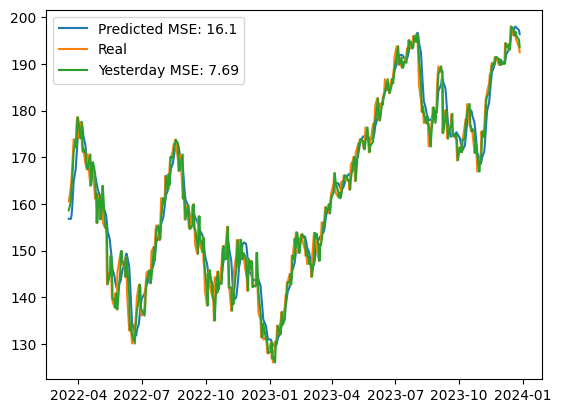

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pred, label=f'Predicted MSE: {round(mse_p.mean(),2)}')
plt.plot(real, label='Real')
plt.plot(yesterday, label=f'Yesterday MSE: {round(mse_y.mean(),2)}')
plt.legend()
plt.show()

In [ ]:
def stck_lstm_fun(trainX, trainY, testX, testY, Y, vdd, epoch, bsize, nhn, win, n_ftrs, ahead, stock, seed, multi):
        '''
        Stack LSTM model

        Returns the evaluation of the model with the test data
        
        Arguments:
        trainX - normalized training data
        trainY - normalized training labels
        testX - normalized test data
        testY - normalized test labels
        Y - output PX_OPEN stock
        vdd - validation dataframe storing the data for normalization and denormalization
        epoch - number of epochs for training
        bsize - batch size for feeding the model
        nhn - number of hidden neurons
        win - window size (days considered to learn from == trainX.shape[1])
        n_ftrs - number of expected outputs (1 in our case)
        stock - stock being evaluated
        ahead - shift value for the stock
        seed - seed to stabilize the repetitions
        '''
        if multi:
            nptrX = trainX.to_numpy().reshape(trainX.shape[0],trainX.shape[1],trainX.shape[2],n_ftrs)
            nptrY = trainY.to_numpy()
        else:
            nptrX = trainX.to_numpy().reshape(trainX.shape[0],trainX.shape[1],n_ftrs)
            nptrY = trainY.to_numpy()
        nit  = 0
        lloss= np.nan
        while math.isnan(lloss) and nit < 5:
            tf.random.set_seed(seed)
            # create a very Stcked-LSTM model
            stmodel = Sequential()
            stmodel.add(LSTM(nhn, activation='relu', return_sequences=True, input_shape=(win,n_ftrs)))
            stmodel.add(LSTM(nhn, activation='relu', return_sequences=True))
            stmodel.add(LSTM(nhn, activation='relu'))
            stmodel.add(Dense(n_ftrs)) # Output of a single value
            stmodel.compile(loss='mean_squared_error', optimizer='adam')
            hist = stmodel.fit(nptrX, nptrY, epochs=epoch, batch_size=bsize, verbose=0)
            lloss= hist.history['loss'][-1]
            nit  = nit + 1
        # Predict
        nptstX = testX.to_numpy().reshape(testX.shape[0],testX.shape[1],n_ftrs)
        nptstY = testY.to_numpy()
        res1   = eval(nptstX, nptstY, testX, stmodel, vdd, Y, ahead)
        df_result = {'MSEP':res1.get("msep"),'MSEY': res1.get("msey"),'Stock':stock,
                    'DY':res1.get("Ys"),'ALG':'STACK-LSTM','seed':seed,'epochs':epoch,
                    'nhn':nhn,'win':win ,'ndims':1, 'lossh':lloss, 'nit':nit,
                    'model':stmodel}
        return(df_result)



In [ ]:


sol   = stck_lstm_fun(trainX,trainY,testX,testY,Y,vdd,epochs,bsize,nhn,win_size,n_ftrs,ahead,stock,seed)